**Linear Regression Tutorial with California housing Dataset**

There are 20,640 samples and 8 features variables in this dataset. The objective is to predict the value of prices of the house using the given features.

In [1]:
import numpy as np
import pandas as pd
import sys


#Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt



#To plot the graph embedded in the notebook
%matplotlib inline

In [2]:
#imports from sklearn library

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

In [3]:
#loading the dataset direclty from sklearn
from sklearn.datasets import fetch_california_housing

In [4]:
california_housing = fetch_california_housing(as_frame=True)
print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [5]:
california_housing.frame.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


As written in the description, the dataset contains aggregated data regarding each district in California. Let’s have a close look at the features that can be used by a predictive model.

In [6]:
california_housing.data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In this dataset, we have information regarding the demography (income, population, house occupancy) in the districts, the location of the districts (latitude, longitude), and general information regarding the house in the districts (number of rooms, number of bedrooms, age of the house). Since these statistics are at the granularity of the district, they corresponds to averages or medians.

Now, let’s have a look to the target to be predicted.

In [7]:
california_housing.target.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

The target contains the median of the house value for each district. Therefore, this problem is a regression problem.

We can now check more into details the data types and if the dataset contains any missing value.

In [8]:
california_housing.frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


**Exploratory Data Analysis**


Exploratory Data Analysis is a very important step before training the model. Here, we will use visualizations to understand the relationship of the target variable with other features.

Let’s first plot the distribution of the target variable. We will use the histogram plot function from the matplotlib library.

We can see that:

*   the dataset contains 20,640 samples and 8 features;
*   all features are numerical features encoded as floating number;
*   there is no missing values.

Let’s have a quick look at the distribution of these features by plotting their histograms.

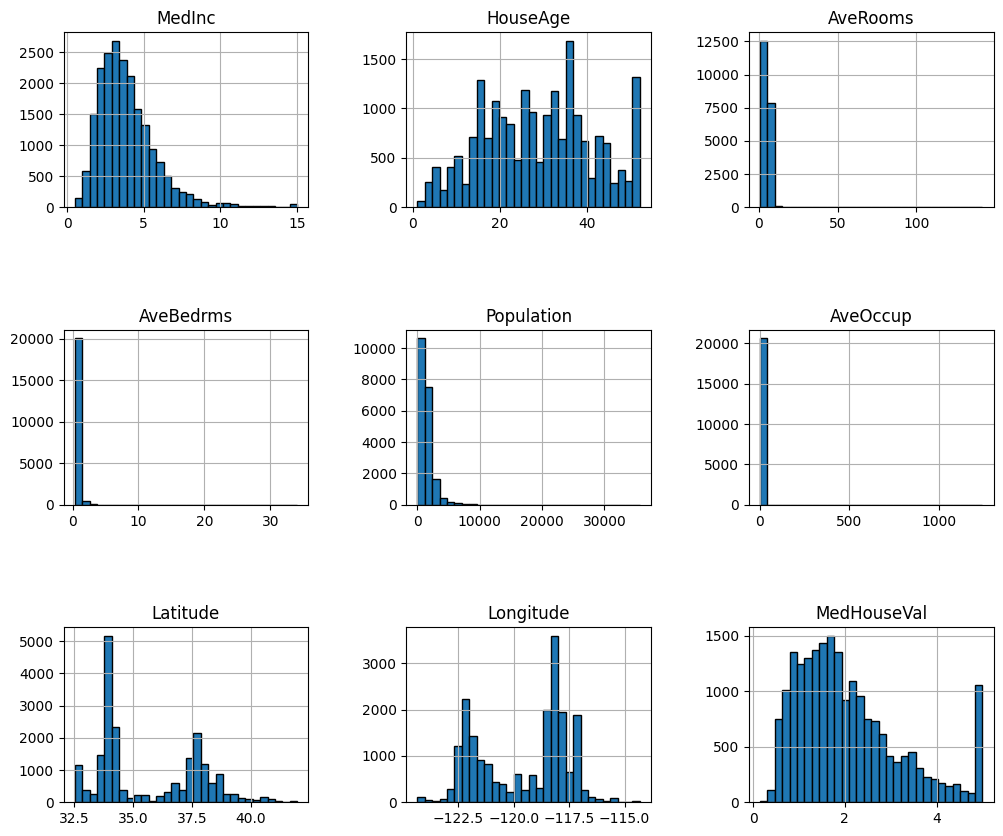

In [9]:
import matplotlib.pyplot as plt

california_housing.frame.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

We can first focus on features for which their distributions would be more or less expected.

The median income is a distribution with a long tail. It means that the salary of people is more or less normally distributed but there is some people getting a high salary.

Regarding the average house age, the distribution is more or less uniform.

The target distribution has a long tail as well. In addition, we have a threshold-effect for high-valued houses: all houses with a price above 5 are given the value 5.

Focusing on the average rooms, average bedrooms, average occupation, and population, the range of the data is large with unnoticeable bin for the largest values. It means that there are very high and few values (maybe they could be considered as outliers?). We can see this specificity looking at the statistics for these features:

In [10]:
features_of_interest = ["AveRooms", "AveBedrms", "AveOccup", "Population"]
california_housing.frame[features_of_interest].describe()

,AveRooms,AveBedrms,AveOccup,Population
count,20640.000000,20640.000000,20640.000000,20640.000000
mean,5.429000,1.096675,3.070655,1425.476744
std,2.474173,0.473911,10.386050,1132.462122
min,0.846154,0.333333,0.692308,3.000000
25%,4.440716,1.006079,2.429741,787.000000
50%,5.229129,1.048780,2.818116,1166.000000
75%,6.052381,1.099526,3.282261,1725.000000
max,141.909091,34.066667,1243.333333,35682.000000


For each of these features, comparing the max and 75% values, we can see a huge difference. It confirms the intuitions that there are a couple of extreme values.

Up to know, we discarded the longitude and latitude that carry geographical information. In short, the combination of this feature could help us to decide if there are locations associated with high-valued houses. Indeed, we could make a scatter plot where the x- and y-axis would be the latitude and longitude and the circle size and color would be linked with the house value in the district.

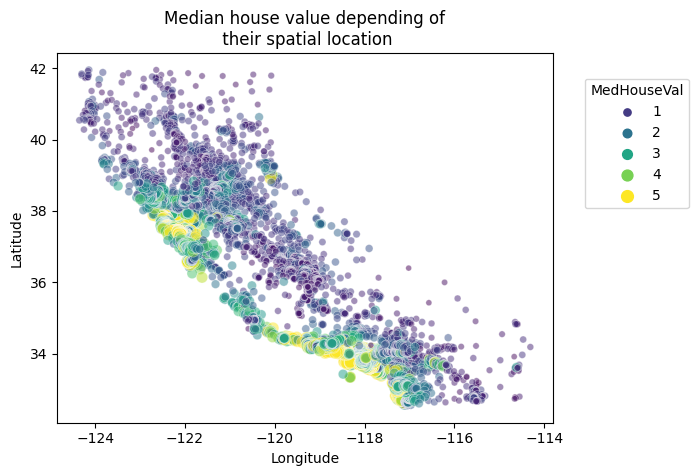

In [11]:
sns.scatterplot(
    data=california_housing.frame,
    x="Longitude",
    y="Latitude",
    size="MedHouseVal",
    hue="MedHouseVal",
    palette="viridis",
    alpha=0.5,
)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95), loc="upper left")
_ = plt.title("Median house value depending of\n their spatial location")

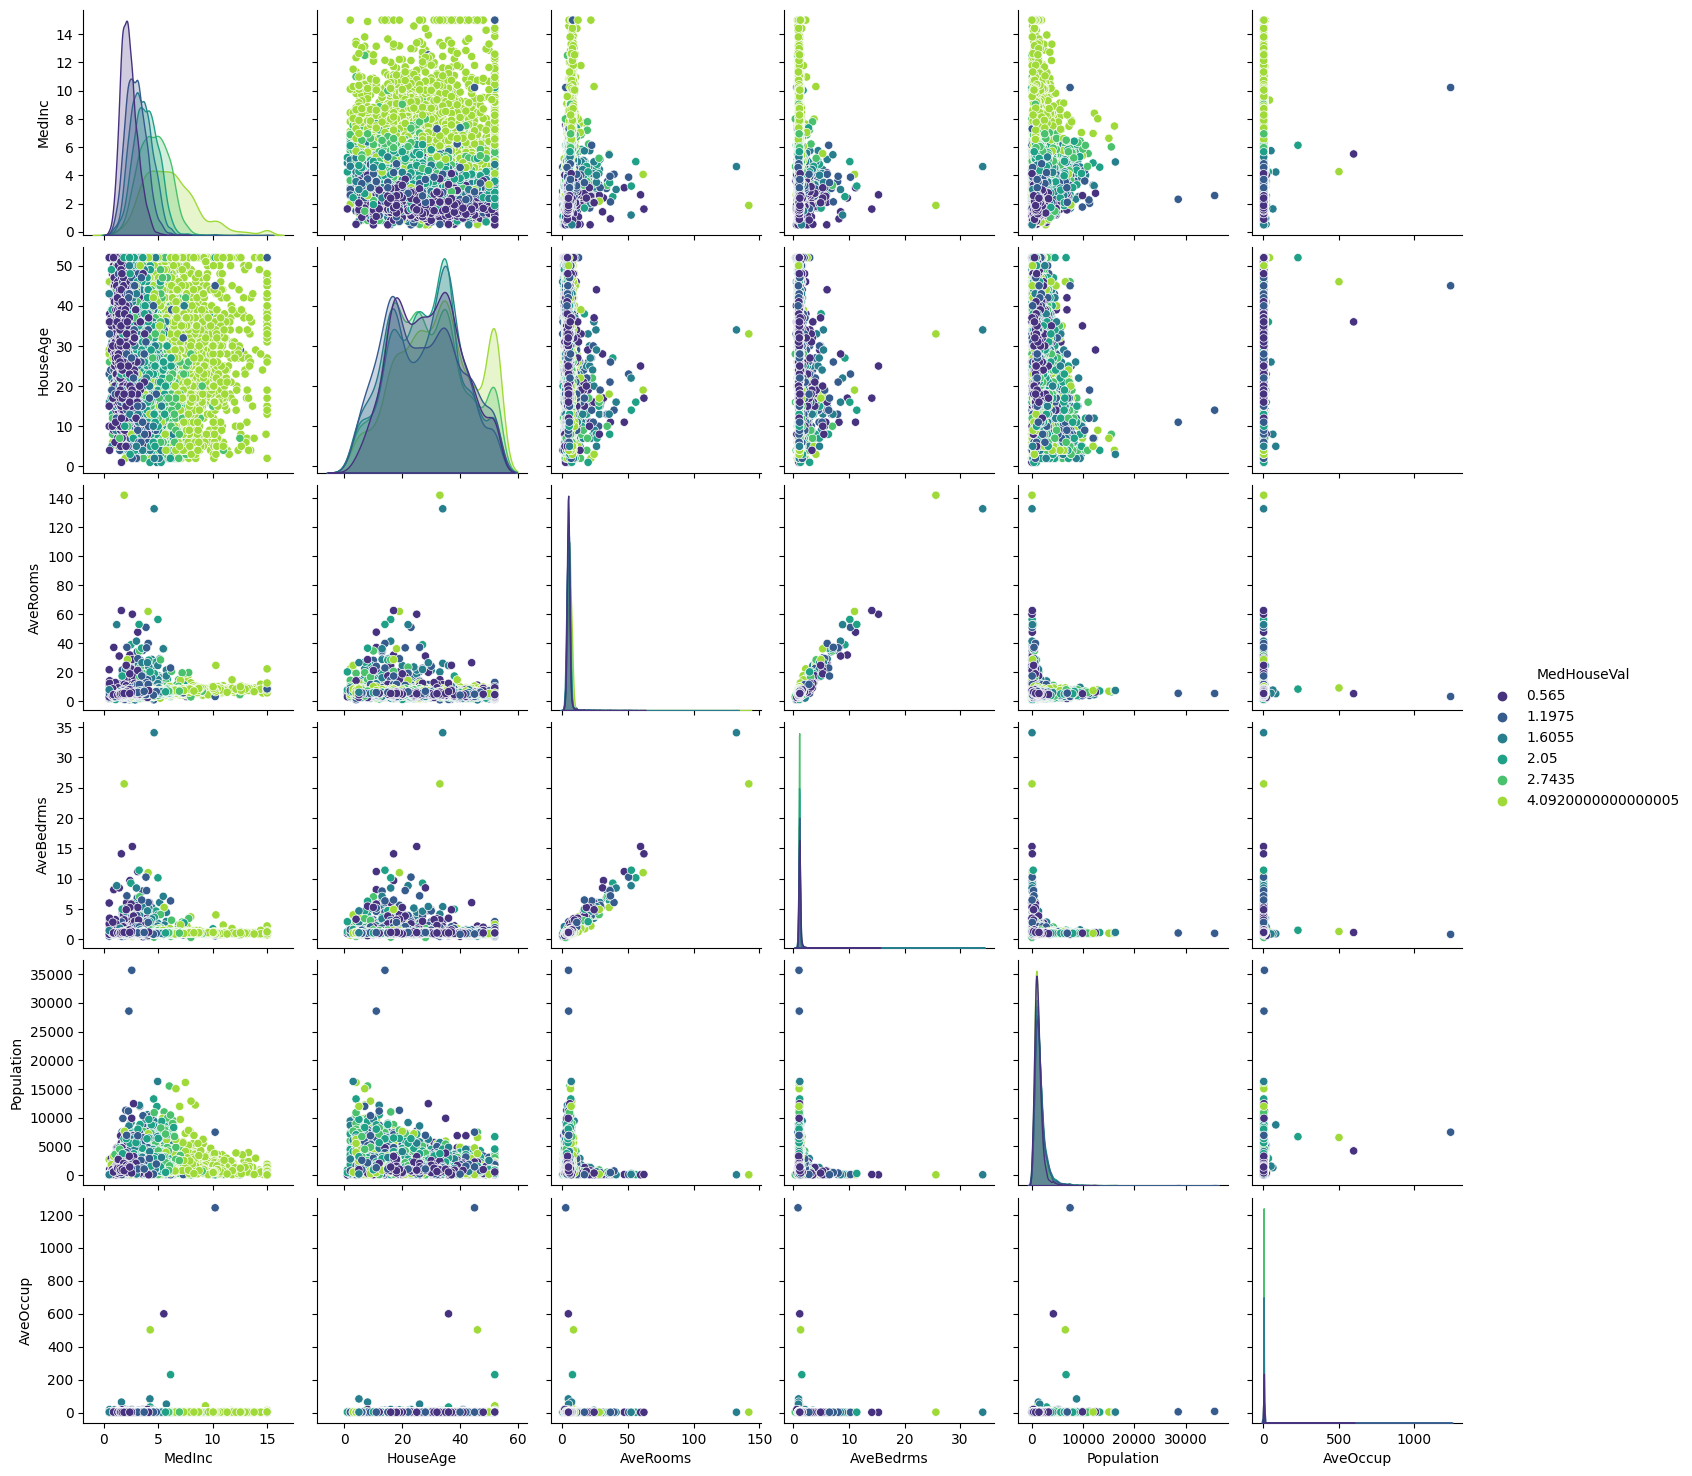

In [12]:
# Drop the unwanted columns
columns_drop = ["Longitude", "Latitude"]
subset = california_housing.frame.drop(columns=columns_drop)
# Quantize the target and keep the midpoint for each interval
subset["MedHouseVal"] = pd.qcut(subset["MedHouseVal"], 6, retbins=False)
subset["MedHouseVal"] = subset["MedHouseVal"].apply(lambda x: x.mid)
_ = sns.pairplot(data=subset, hue="MedHouseVal", palette="viridis")

<Axes: >

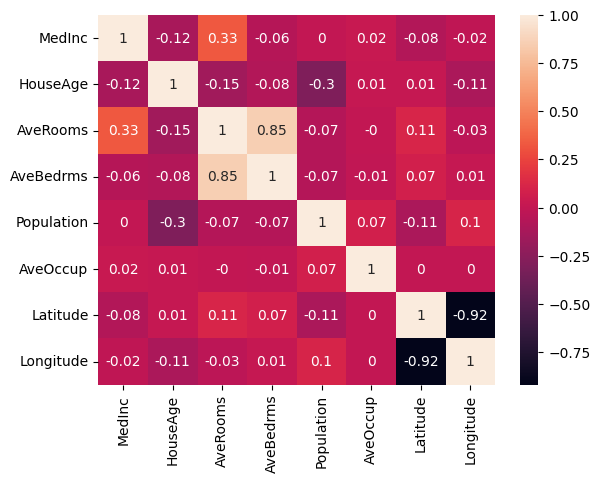

In [13]:
#Created a dataframe without the MedHouseVal, since we need to see the correlation between the variables
california_1 = pd.DataFrame(california_housing.data, columns = california_housing.feature_names)

correlation_matrix = california_1.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

<Axes: >

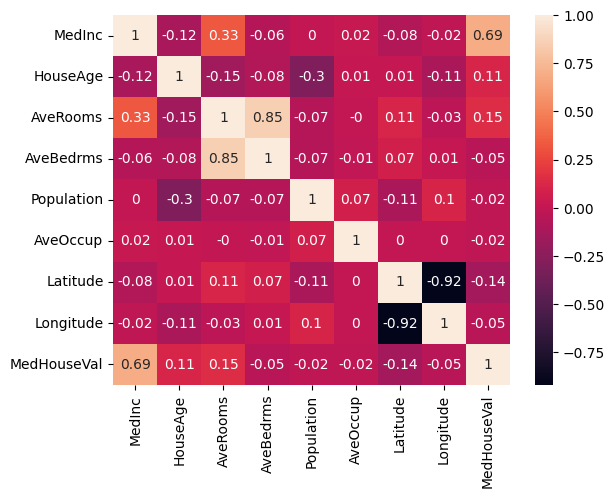

In [14]:
#Created a dataframe with the MedHouseVal

sns.heatmap(data=california_housing.frame.corr().round(2), annot=True)

**Notice**

1.   By looking at the correlation matrix we can see that **MedHouseVal** has a positive correlation with **MedInc** (0.69).

2. An important point in selecting features for a linear regression model is to
check for multicolinearity. The feature **LATITUDE** has a strong negative correlation with **LONGITUDE** (-0.92). These feature pairs are strongly correlated to each other. This can affect the model. Same goes for the features **AveRooms**, **AveBedrms** has a strong positive correlation with (0.85).



But for now we will keep all the features.

In [15]:
X_income = california_housing.frame.MedInc
y_price = california_housing.frame.MedHouseVal


X_income = np.array(X_income).reshape(-1,1)
y_price1 = np.array(y_price).reshape(-1,1)

print(X_income.shape)
print(y_price1.shape)

(20640, 1)
(20640, 1)


In [16]:
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_income, y_price1, test_size = 0.25, random_state=5)

print(X_train_1.shape)
print(X_test_1.shape)
print(Y_train_1.shape)
print(Y_test_1.shape)

(15480, 1)
(5160, 1)
(15480, 1)
(5160, 1)


**Training and testing the model**
Here we use scikit-learn’s LinearRegression to train our model on both the training and check it on the test sets. and check the model performance on the train dataset.

In [17]:
reg_1 = LinearRegression()
reg_1.fit(X_train_1, Y_train_1)
y_train_predict_1 = reg_1.predict(X_train_1)


mse_1 = mean_squared_error(Y_train_1, y_train_predict_1)
rmse_1 = (np.sqrt(mean_squared_error(Y_train_1, y_train_predict_1)))
r2_1 = round(r2_score(Y_train_1, y_train_predict_1),2)

print("The model performance for training set")
print("--------------------------------------")
print('MSE_1 is {}'.format(mse_1))
print('RMSE_1 is {}'.format(rmse_1))
print('R2_1 score is {}'.format(r2_1))
print("\n")

The model performance for training set
--------------------------------------
MSE_1 is 0.6991752324280739
RMSE_1 is 0.8361669883630146
R2_1 score is 0.47




In [18]:
y_test_pred_1 = reg_1.predict(X_test_1)

mse = mean_squared_error(Y_test_1, y_test_pred_1)
rmse = (np.sqrt(mean_squared_error(Y_test_1, y_test_pred_1)))
r2 = round(r2_score(Y_test_1, y_test_pred_1),2)

print("The model performance for test set")
print("--------------------------------------")
print("MSE_1_test: {}".format(mse))
print("RMSE_1_test: {}".format(rmse))
print("R^2_1_score: {}".format(r2))
print("\n")

The model performance for test set
--------------------------------------
MSE_1_test: 0.7070723299566921
RMSE_1_test: 0.8408759301803639
R^2_1_score: 0.48




Plotting the model fitted line on the output variable.

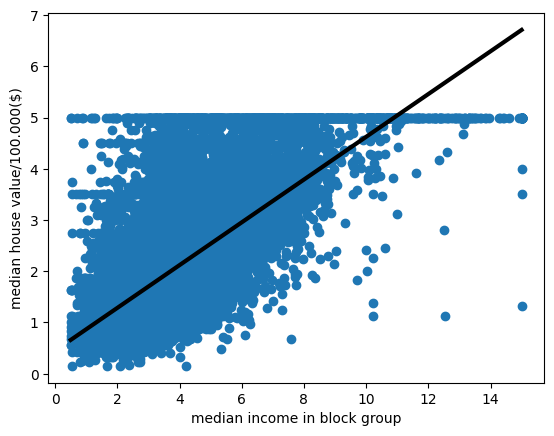

In [19]:
prediction_space = np.linspace(min(X_income), max(X_income)).reshape(-1,1)
plt.scatter(X_income,y_price)
plt.plot(prediction_space, reg_1.predict(prediction_space), color = 'black', linewidth = 3)
plt.ylabel('median house value/100.000($)')
plt.xlabel('median income in block group')
plt.show()

**Regression Model for All the variables**
Now we will create a model considering all the features in the dataset. The process is almost the same and also the evaluation model

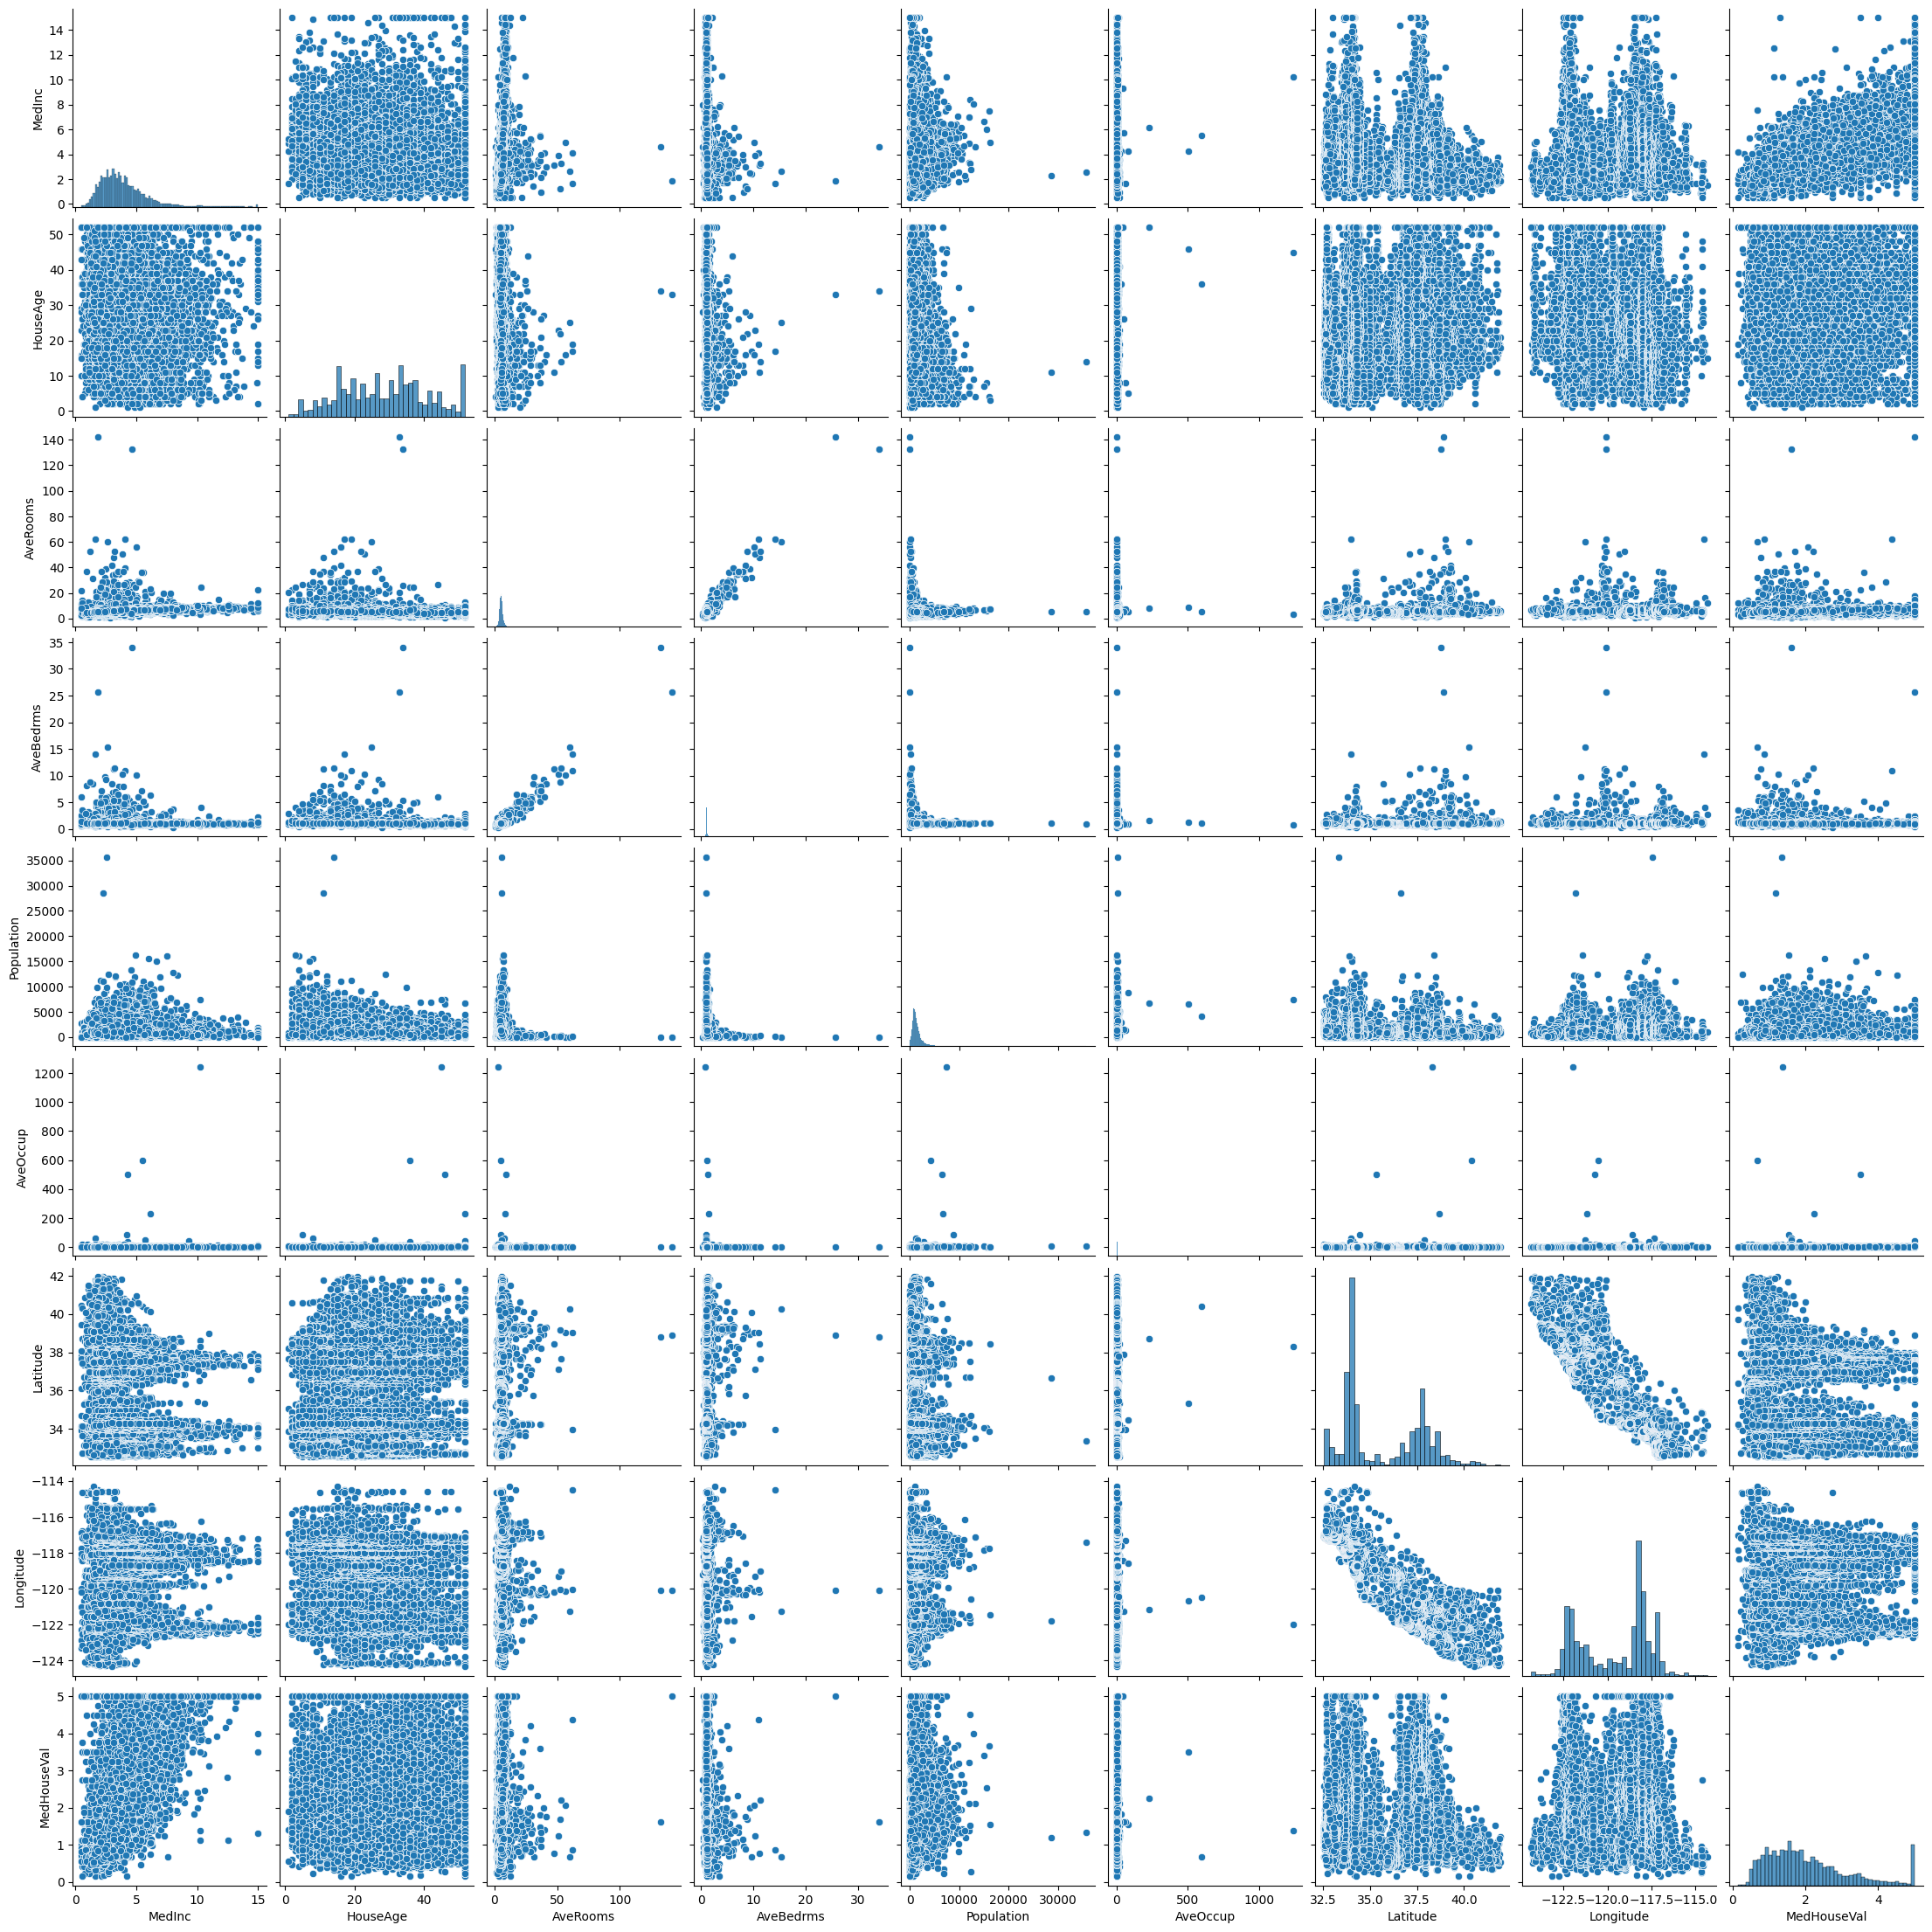

In [20]:
sns.pairplot(california_housing.frame)

In [21]:
X_total = california_housing.data
y_price = california_housing.target



y_price = np.array(y_price).reshape(-1,1)

print(X_total.shape)
print(y_price.shape)

(20640, 8)
(20640, 1)


**Splitting the data into training and testing sets**
Next, we split the data into training and testing sets. We train the model with 80% of the samples and test with the remaining 20%. *We do this to assess the model’s performance on unseen data*. To split the data we use *train_test_split* function provided by scikit-learn library. We finally print the sizes of our training and test set to verify if the splitting has occurred properly.



In [22]:
X_train_t, X_test_t, Y_train_t, Y_test_t = train_test_split(X_total, y_price, test_size = 0.2, random_state=5)

print(X_train_t.shape)
print(X_test_t.shape)
print(Y_train_t.shape)
print(Y_test_t.shape)

(16512, 8)
(4128, 8)
(16512, 1)
(4128, 1)


In [23]:
reg_t = LinearRegression()
reg_t.fit(X_train_t, Y_train_t)

y_train_predict_t = reg_t.predict(X_train_t)
mse_t_train = mean_squared_error(Y_train_t, y_train_predict_t)
rmse_t_train = (np.sqrt(mean_squared_error(Y_train_t, y_train_predict_t)))
r2_t_train = round(r2_score(Y_train_t, y_train_predict_t),2)

print("The model performance for training set")
print("--------------------------------------")
print('MSE_t_train is {}'.format(mse_t_train))
print('RMSE_t_train is {}'.format(rmse_t_train))
print('R2_t_train score is {}'.format(r2_t_train))
print("\n")

The model performance for training set
--------------------------------------
MSE_t_train is 0.5214403564745769
RMSE_t_train is 0.7221082719887488
R2_t_train score is 0.6




In [24]:
y_test_predict_t = reg_t.predict(X_test_t)

mse_t_test = mean_squared_error(Y_test_t, y_test_predict_t)
rmse_t_test = (np.sqrt(mean_squared_error(Y_test_t, y_test_predict_t)))
r2_t_test = round(r2_score(Y_test_t, y_test_predict_t),2)

print("The model performance for training set")
print("--------------------------------------")
print('MSE_test_t is {}'.format(mse_t_test))
print('RMSE_test_t is {}'.format(rmse_t_test))
print('R2_test_t score is {}'.format(r2_t_test))
print("\n")

The model performance for training set
--------------------------------------
MSE_test_t is 0.5363427302501913
RMSE_test_t is 0.7323542382277796
R2_test_t score is 0.61




**Lasso**
The consequence of L1 regularization is that when using the lasso, some coefficients are exactly zero. This means some features are entirely ignored by the model. This can be seen as a form of automatic feature selection. Having some coefficients be exactly zero often makes a model easier to interpret, and can reveal the most important features of your model.

In [25]:
lasso_train = Lasso(alpha= 0.2)
lasso_train.fit(X_train_t, Y_train_t)

y_train_predict_lasso_t = lasso_train.predict(X_train_t)

mse_lasso_train = mean_squared_error(Y_train_t, y_train_predict_lasso_t)
rmse_lasso_train = (np.sqrt(mean_squared_error(Y_train_t, y_train_predict_lasso_t)))
r2_lasso_train = round(r2_score(Y_train_t, y_train_predict_lasso_t),2)

print("The model performance for training set")
print("--------------------------------------")
print('MSE_lasso_train is {}'.format(mse_lasso_train))
print('RMSE_lasso_train is {}'.format(rmse_lasso_train))
print('R2_lasso_train score is {}'.format(r2_lasso_train))

print("\n")



The model performance for training set
--------------------------------------
MSE_lasso_train is 0.6586745482228437
RMSE_lasso_train is 0.8115876713102803
R2_lasso_train score is 0.5




In [27]:
y_test_predict_lasso_t = lasso_train.predict(X_test_t)

mse_lasso_test = mean_squared_error(Y_test_t, y_test_predict_lasso_t)
rmse_lasso_test = (np.sqrt(mean_squared_error(Y_test_t, y_test_predict_lasso_t)))
r2_lasso_test = round(r2_score(Y_test_t, y_test_predict_lasso_t),2)

print("The model performance for training set")
print("--------------------------------------")
print('MSE_lasso_test is {}'.format(mse_lasso_test))
print('RMSE_lasso_test is {}'.format(rmse_lasso_test))
print('R2_lasso_test score is {}'.format(r2_lasso_test))
print("\n")

The model performance for training set
--------------------------------------
MSE_lasso_test is 0.666250138925737
RMSE_lasso_test is 0.8162414709666111
R2_lasso_test score is 0.52




The *alpha* parameter controls the degree of sparsity of the estimated coefficients.

In [28]:

mse_valida = []
mae_valida = []
r2_valida = []
alpha = [0.01, 0.1,0.2,0.4,0.8,1,2,10,20,30,50,100, 150, 200, 250, 300, 350]
for x in alpha:

    LassoModel = Lasso(alpha = x)
    LassoModel.fit(X_test_t, Y_test_t)
    y_pred_lassoF = LassoModel.predict(X_test_t)

    mse_valida.append(round(mean_squared_error(Y_test_t, y_pred_lassoF),4))
    mae_valida.append(round(median_absolute_error(Y_test_t, y_pred_lassoF),4))
    r2_valida.append(round(r2_score(Y_test_t, y_pred_lassoF),2))



In [29]:
pd.options.display.float_format = '{:.3f}'.format
results = pd.DataFrame(np.array([alpha, mse_valida, mae_valida, r2_valida], dtype='float').T, columns = ['alpha', 'mse', 'mae', 'r2'])
results



,alpha,mse,mae,r2
0,0.010,0.539,0.433,0.610
1,0.100,0.612,0.469,0.560
2,0.200,0.663,0.501,0.520
3,0.400,0.700,0.532,0.490
4,0.800,0.836,0.618,0.390
5,1.000,0.938,0.659,0.320
6,2.000,1.377,0.784,0.000
7,10.000,1.377,0.784,0.000
8,20.000,1.377,0.785,0.000
9,30.000,1.377,0.785,0.000


**Let's remember:**
Ridge will help us when we suspect that several of the input attributes (features) are correlated with each other. Ridge causes the coefficients to end up smaller. This lowering of the coefficients minimizes the effect of the correlation between the input attributes and makes the model generalize better. Ridge works best when most of the attributes are relevant.

we compare the models

In [30]:
comparison_model = pd.DataFrame( index=["Reg_Lin", "Reg_Lin_Norm", "Ridge", "Ridge_Norm", "Lasso"], columns=['alpha1', 'mse', 'mae', 'r2'])
alpha1=0.1
comparison_model.loc['Reg_Lin']=[0, mse_t_test,rmse_t_test , r2_t_test]
comparison_model.loc['Lasso']=[alpha1, mse_lasso_test,rmse_lasso_test , r2_lasso_test]
comparison_model

,alpha1,mse,mae,r2
Reg_Lin,0,0.536,0.732,0.610
Reg_Lin_Norm,NaN,NaN,NaN,NaN
Ridge,NaN,NaN,NaN,NaN
Ridge_Norm,NaN,NaN,NaN,NaN
Lasso,0.100,0.666,0.816,0.520



**EXERCISE**

1. If some variables are removed, is it possible to find a model with greater precision? Run some tests and if you find a better model, present your results.
2. Normalize the data in the dataset and run a linear regression model on this normalized data. Label it as: Reg_Lin_Norm
3. Evaluate a Ridge model with the original dataset and another Ridge model with the normalized database (specify if you use all the variables or only some of them). Label them as: Ridge and Ridge_Norm, respectively.
4. Complite table "model comparison".

